In [1]:
import sys
import os
import requests
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import models_mae

### Define utils

In [2]:
# define the utils

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def prepare_model(chkpt_dir, arch='mae_vit_large_patch16'):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def run_one_image(img, model):
    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # run MAE
    loss, y, mask = model(x.float(), mask_ratio=0.75)
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()

    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()

### Load an image

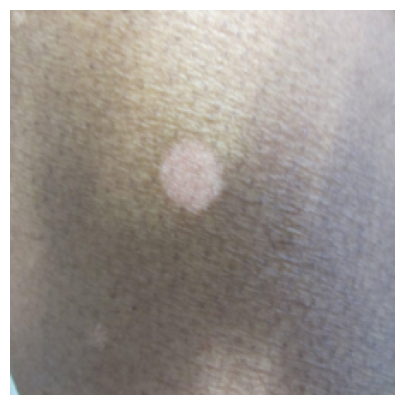

In [3]:
# load an image
# img_url = './RET030OD.jpg' # fox, from ILSVRC2012_val_00046145
# img_url = 'https://user-images.githubusercontent.com/11435359/147743081-0428eecf-89e5-4e07-8da5-a30fd73cc0ba.jpg' # cucumber, from ILSVRC2012_val_00047851
# img_url = 'img_1.jpg'
img_url = '/home/sajib/RETFound_MAE/DDI_data/train/malignant/000003.png'
img = Image.open(img_url)
img = img.resize((224, 224))
img = np.array(img) / 255.

assert img.shape == (224, 224, 3)

# normalize by ImageNet mean and std
img = img - imagenet_mean
img = img / imagenet_std

plt.rcParams['figure.figsize'] = [5, 5]
show_image(torch.tensor(img))

### Load a pre-trained MAE model

In [4]:
# This is an MAE model trained with pixels as targets for visualization (ViT-Large, training mask ratio=0.75)

# download checkpoint if not exist
chkpt_dir = './RETFound_cfp_weights.pth'
model_mae = prepare_model(chkpt_dir, 'mae_vit_large_patch16')
print('Model loaded.')


<All keys matched successfully>
Model loaded.


### Run MAE on the image

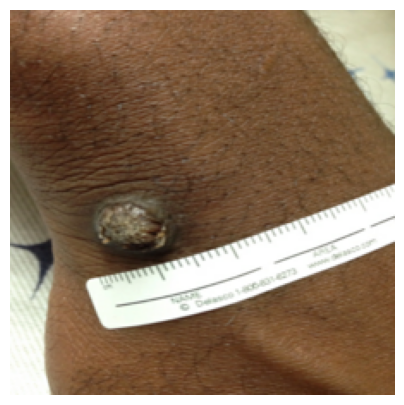

In [24]:
img_url = '/home/sajib/RETFound_MAE/DDI_data/train/benign/000063.png'
img = Image.open(img_url)
img = img.resize((224, 224))
img = np.array(img) / 255.

assert img.shape == (224, 224, 3)

# normalize by ImageNet mean and std
img = img - imagenet_mean
img = img / imagenet_std

plt.rcParams['figure.figsize'] = [5, 5]
show_image(torch.tensor(img))

MAE with pixel reconstruction:


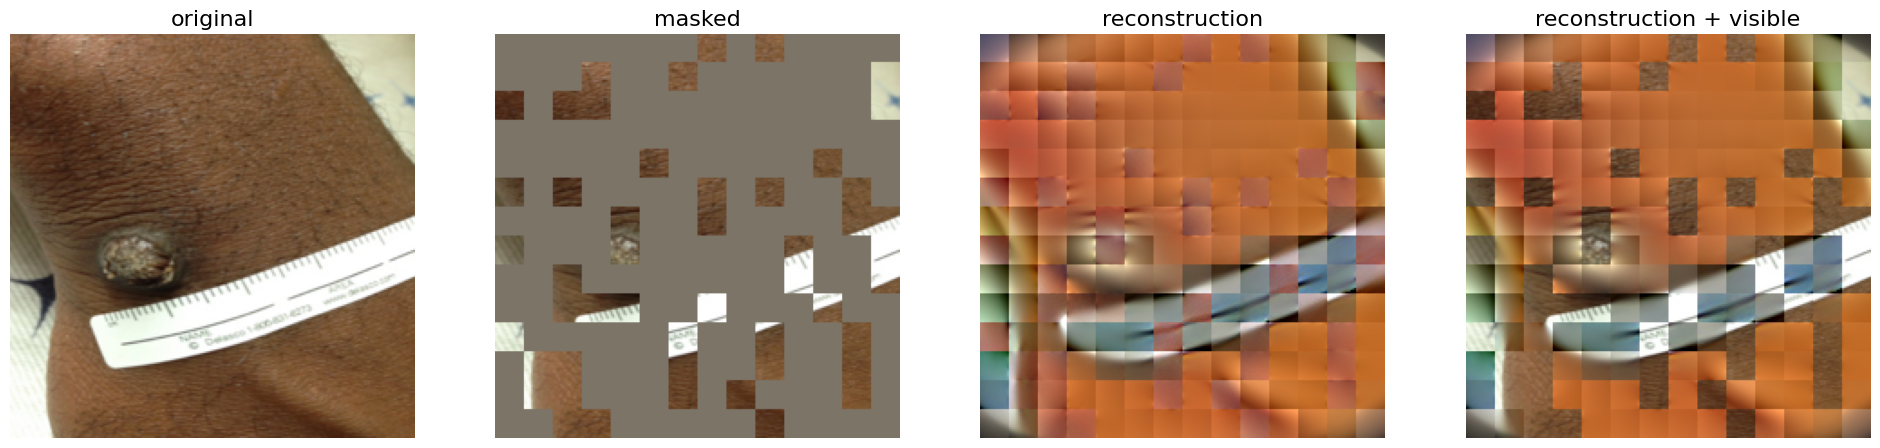

In [25]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)
print('MAE with pixel reconstruction:')
run_one_image(img, model_mae)

In [26]:
!pip install numpy scipy matplotlib pillow


In [27]:
import numpy as np
from scipy.stats import pearsonr
from PIL import Image

def calculate_image_correlation(image_path1, image_path2):
    # Load images and convert to grayscale
    image1 = Image.open(image_path1).convert('L')
    image2 = Image.open(image_path2).convert('L')
    
    # Resize images to match (if they are different sizes)
    # Note: It's better if images are originally the same size
    if image1.size != image2.size:
        image2 = image2.resize(image1.size)
    
    # Convert images to numpy arrays
    image_array1 = np.array(image1).flatten()
    image_array2 = np.array(image2).flatten()
    
    # Calculate Pearson correlation coefficient
    correlation, _ = pearsonr(image_array1, image_array2)
    
    return correlation

# Example usage
image_path1 = '/home/sajib/RETFound_MAE/DDI_data/train/malignant/000006.png'
image_path2 = '/home/sajib/RETFound_MAE/IDRiD_data/train/anoDR/IDRiD_118.png'
correlation = calculate_image_correlation(image_path1, image_path2)
print(f"Pearson correlation coefficient: {correlation}")


Pearson correlation coefficient: 0.22053191646240425


In [32]:
import torch
from torchvision import models, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Load a pre-trained model
model = models.resnet50(pretrained=True)
model.eval()  # Set the model to evaluation mode

# Remove the final layer to get feature extractor
model = torch.nn.Sequential(*(list(model.children())[:-1]))

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load datasets
dataset1 = ImageFolder('/home/sajib/RETFound_MAE/DDI_data/train/malignant', transform=transform)
dataset2 = ImageFolder('/home/sajib/RETFound_MAE/IDRiD_data/train/anoDR', transform=transform)

# Create DataLoaders
dataloader1 = DataLoader(dataset1, batch_size=32, shuffle=False)
dataloader2 = DataLoader(dataset2, batch_size=32, shuffle=False)

# Function to extract features
def extract_features(dataloader):
    features = []
    with torch.no_grad():
        for inputs, _ in dataloader:
            outputs = model(inputs).squeeze()  # Remove batch dim and extra dims
            features.append(outputs)
    return torch.cat(features).numpy()

# Extract features
features1 = extract_features(dataloader1)
features2 = extract_features(dataloader2)

# Example: Compare feature distributions using t-SNE visualization
tsne = TSNE(n_components=2, random_state=0)
all_features = np.vstack((features1, features2))
all_features_2d = tsne.fit_transform(all_features)

# Plotting
plt.figure(figsize=(10, 5))
plt.scatter(all_features_2d[:len(features1), 0], all_features_2d[:len(features1), 1], color='r', label='Dataset 1')
plt.scatter(all_features_2d[len(features1):, 0], all_features_2d[len(features1):, 1], color='b', label='Dataset 2')
plt.legend()
plt.title('t-SNE visualization of feature distributions')
plt.show()


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/sajib/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html